# Classification Models
Now we will attempt to create classiffication Models that can accurately predict the outcomes of Terry Stops Based on the data as recorded by Seattle.gov

In [1]:
from imports import *

In [2]:
#load data
df = pd.read_csv('data/cleaned_df.csv')

#change frisk and arrest flags to 1 and 0

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Frisk_Flag                52147 non-null  int64 
 7   Officer_Age               52147 non-null  int64 
 8   Legal_Action_Taken        52147 non-null  int64 
 9   Arrested                  52147 non-null  int64 
 10  Physical_Arrest           52147 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.4+ MB


## Target: Physical Arrest

First we attempt to create a classifier that can determine whether legal action was taken. So we will remove the other target variables entirely.

In [3]:
df.drop(['Arrested', 'Legal_Action_Taken'], axis=1, inplace=True)
#df.info()

### Categorical Variables
Next the non-numeric variables need to be split into data types that can be properly interpreted by our classifiers.


In [4]:
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.columns = dummies_df.columns.str.replace(' ','_')
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 27 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Frisk_Flag                                                        52147 non-null  int64
 1   Officer_Age                                                       52147 non-null  int64
 2   Physical_Arrest                                                   52147 non-null  int64
 3   Subject_Age_Group_1_-_17                                          52147 non-null  uint8
 4   Subject_Age_Group_18_-_25                                         52147 non-null  uint8
 5   Subject_Age_Group_26_-_35                                         52147 non-null  uint8
 6   Subject_Age_Group_36_-_45                                         52147 non-null  uint8
 7   Subject_Age_Group_46_-_55                        

### Splitting Data

Now we separate the data into train and test sets, and scale the features so that our algorithms can properly interpret them.

In [5]:
#separate arrest outcome and train test split

X= dummies_df.drop('Physical_Arrest', axis=1)
y = dummies_df['Physical_Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Choosing Evaluation Metric Functions

We want to focus on the Precision and Recall, and by extension the F1 score because we want to avoid both false positives and false negatives in our evaluation.

Accuracy alone would not be a good metric as our data contains an imbalance in target variables, and a model predicting "No Action Taken" stands a good chance to be accurate in most cases. 

We can also visualize, when necessary, confusion matrices to see the exact distributions of True Positives, False Positives, True Negatives, and False Negatives.


The code that shows us these scores can be found in [functions.py](./functions.py)


### Baseline Model

We start with a baseline Logistic Regression Model.

In [6]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

AUC: 0.6483675061248404


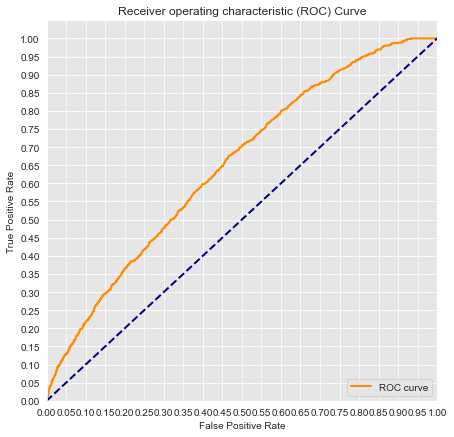

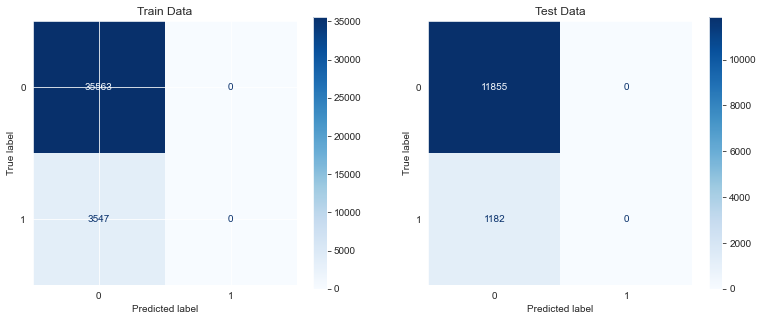

Train Data:                                 Test Data:
Accuracy:  0.9093070825875735               Accuracy:  0.9093349697016184
Recall:    0.0                              Recall:    0.0       
Precision: 0.0                              Precision: 0.0       
F1:        0.0                              F1:        0.0       


In [7]:
plot_ROC(logreg, X_test, y_test)

plot_confusion(logreg,X_train, X_test, y_train, y_test)

clf_scores(logreg,X_train, X_test, y_train, y_test)

### Scoring 
As expected, Accuracy is very high since a large percentage our data reports no Physical Arrests being made. The ROC AUC Score is understandably hard to take any value from for this reason.

In [8]:
print(y_train.value_counts())
print(y_test.value_counts())

0    35563
1     3547
Name: Physical_Arrest, dtype: int64
0    11855
1     1182
Name: Physical_Arrest, dtype: int64


### Class Imbalance
The current assortment of target values is highly imbalanced, so we will also use SMOTE to create synthetic data, and see if this improves our scores.

In [9]:
smote = SMOTE(random_state = 42)
X_train_synth, y_train_synth = smote.fit_resample(X_train, y_train)
y_train_synth.value_counts()

1    35563
0    35563
Name: Physical_Arrest, dtype: int64

In [10]:
#Test again with synthetic data:
logreg_synth = LogisticRegression(max_iter=1000)
logreg_synth.fit(X_train_synth, y_train_synth)

LogisticRegression(max_iter=1000)

AUC: 0.5842102220785421


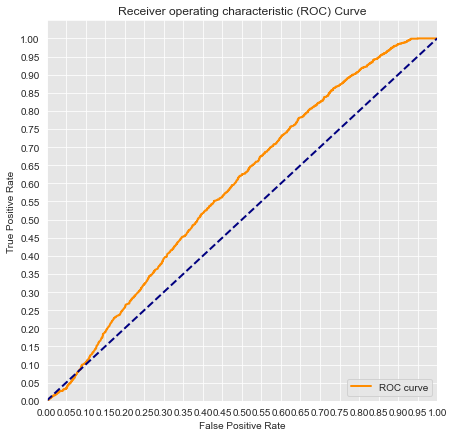

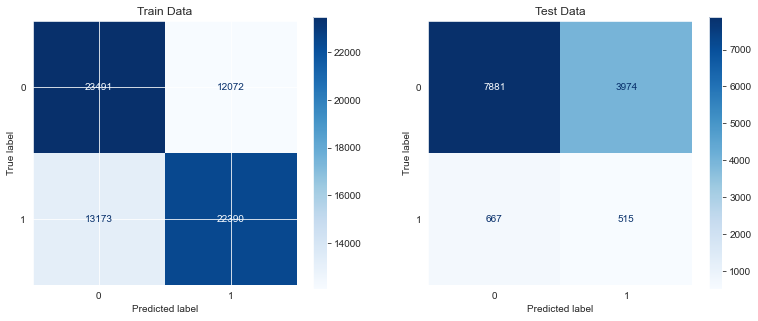

Train Data:                                 Test Data:
Accuracy:  0.6450665017012063               Accuracy:  0.644013193219299
Recall:    0.6295869302364817               Recall:    0.4357021996615905
Precision: 0.6497011200742847               Precision: 0.11472488304744932
F1:        0.6394858978936094               F1:        0.18162581555281254


In [11]:
plot_confusion(logreg_synth, X_train_synth, X_test, y_train_synth, y_test)
clf_scores(logreg_synth, X_train_synth, X_test, y_train_synth, y_test)

### SMOTE effects

These scores are not great, but at least our model no longer scores a 0 in all metrics other than Accuracy. However, there is a clear imbalance between Logisitic Regressions success with the training data vs the testing data. Going forward in this notebook, we will observe the classifiers performance with and without SMOTE to gain a stronger understanding of its actual effects on our scores.

## Comparing Classifiers
Now we will run through various other classifiers. We will first observe the performance of each classifier with its baseline paramters, and choose the appropriate model to explore further.

We will test KNN, Decision Trees, Random Forest, and XGBoost. The most important scoring metric for this analysis will be a classifier's F1 score, particularly on the test data.

### K Nearest Neighbors
KNN needs our data to be scaled with StandardScaler in order to function appropriately.

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

KNN:


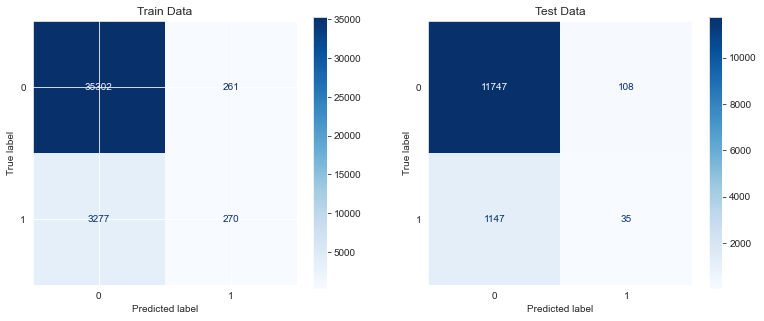

Train Data:                                 Test Data:
Accuracy:  0.9095372027614421               Accuracy:  0.9037355219759147
Recall:    0.07612066535100084              Recall:    0.02961082910321489
Precision: 0.5084745762711864               Precision: 0.24475524475524477
F1:        0.13241785188818048              F1:        0.05283018867924528


In [14]:
print('KNN:')
plot_confusion(knn,X_train_scaled, X_test_scaled,y_train, y_test)
clf_scores(knn, X_train_scaled, X_test_scaled,y_train, y_test)

KNN With Synthetic Data:


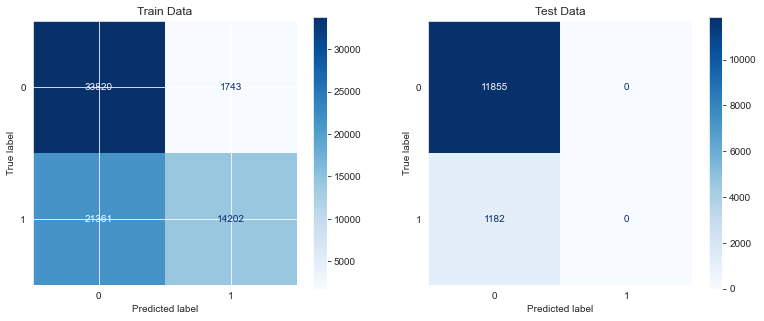

Train Data:                                 Test Data:
Accuracy:  0.6751680116975508               Accuracy:  0.9093349697016184
Recall:    0.39934763658858924              Recall:    0.0       
Precision: 0.89068673565381                 Precision: 0.0       
F1:        0.5514483187077736               F1:        0.0       


In [15]:
#With SMOTE

X_train_synth_scaled = scaler.fit_transform(X_train_synth)

knn_synth = KNeighborsClassifier()
knn_synth.fit(X_train_synth_scaled, y_train_synth)

print('KNN With Synthetic Data:')
plot_confusion(knn_synth, X_train_synth_scaled, X_test, y_train_synth, y_test)
clf_scores(knn_synth, X_train_synth_scaled, X_test, y_train_synth, y_test)

### Decision Tree

In [16]:
dectree = DecisionTreeClassifier(random_state=42)
dectree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Decision Tree:


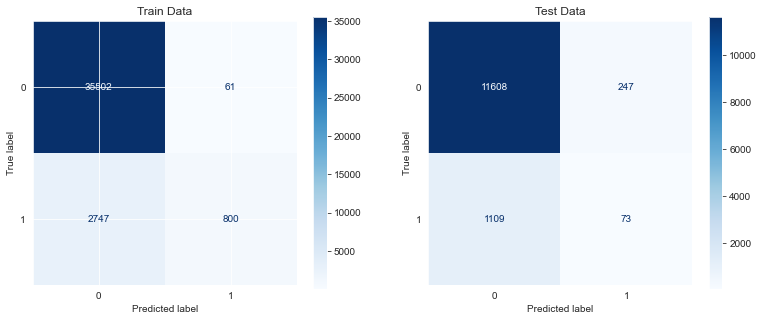

Train Data:                                 Test Data:
Accuracy:  0.9282025057530043               Accuracy:  0.8959883408759683
Recall:    0.22554271215111363              Recall:    0.06175972927241963
Precision: 0.9291521486643438               Precision: 0.228125  
F1:        0.3629764065335753               F1:        0.09720372836218376


In [17]:
print('Decision Tree:')
plot_confusion(dectree,X_train, X_test, y_train, y_test)
clf_scores(dectree,X_train, X_test,y_train, y_test)

Decisiton Tree With Synthetic Data:


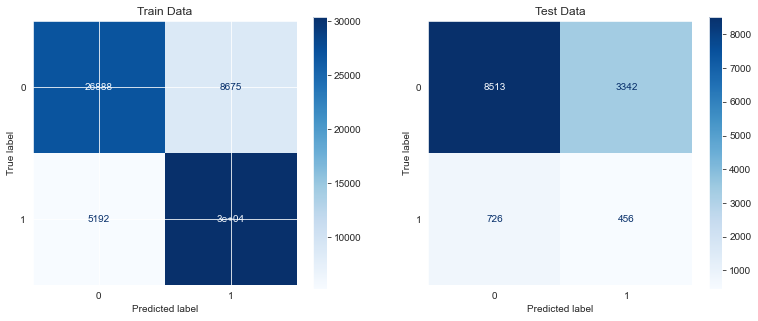

Train Data:                                 Test Data:
Accuracy:  0.8050361330596406               Accuracy:  0.6879650226279052
Recall:    0.854005567584287                Recall:    0.38578680203045684
Precision: 0.7778261537673513               Precision: 0.12006319115323855
F1:        0.8141377045664732               F1:        0.18313253012048192


In [18]:
dectree_synth = DecisionTreeClassifier(random_state=42)
dectree_synth.fit(X_train_synth, y_train_synth)

print('Decisiton Tree With Synthetic Data:')
plot_confusion(dectree_synth, X_train_synth, X_test, y_train_synth, y_test)
clf_scores(dectree_synth, X_train_synth, X_test, y_train_synth, y_test)

### Random Forest

In [19]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Random Forest:


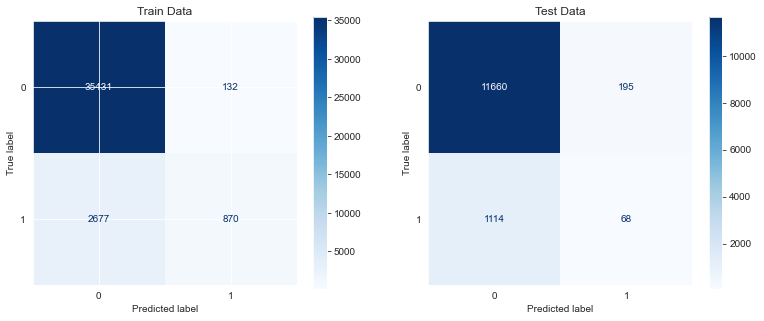

Train Data:                                 Test Data:
Accuracy:  0.9281769368447967               Accuracy:  0.8995934647541612
Recall:    0.24527769946433606              Recall:    0.05752961082910321
Precision: 0.8682634730538922               Precision: 0.2585551330798479
F1:        0.38250164871400305              F1:        0.09411764705882351


In [20]:
print('Random Forest:')
plot_confusion(forest,X_train, X_test, y_train, y_test)
clf_scores(forest,X_train, X_test,y_train, y_test)

Random Forest With Synthetic Data:


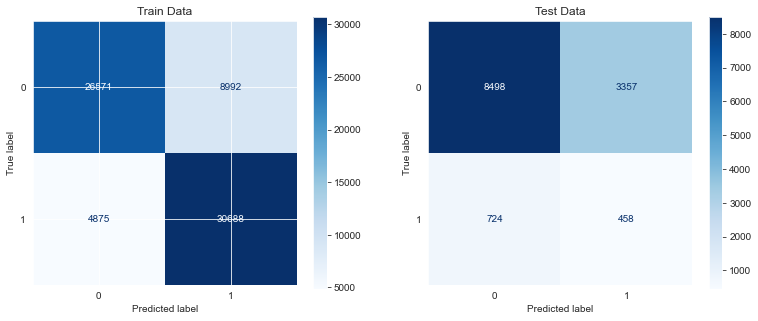

Train Data:                                 Test Data:
Accuracy:  0.8050361330596406               Accuracy:  0.6869678607041497
Recall:    0.862919326266063                Recall:    0.38747884940778343
Precision: 0.7733870967741936               Precision: 0.1200524246395806
F1:        0.8157037863987348               F1:        0.18330998599159493


In [21]:
forest_synth = RandomForestClassifier(random_state=42)
forest_synth.fit(X_train_synth, y_train_synth)

print('Random Forest With Synthetic Data:')
plot_confusion(forest_synth, X_train_synth, X_test, y_train_synth, y_test)
clf_scores(forest_synth, X_train_synth, X_test, y_train_synth, y_test)

### XGBoost

In [22]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

XG Boost Scores


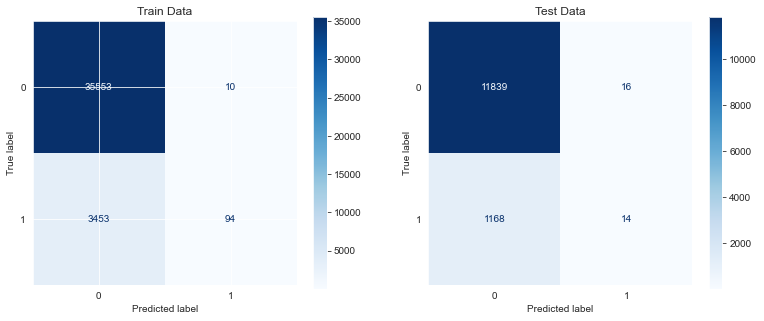

Train Data:                                 Test Data:
Accuracy:  0.9114548708770136               Accuracy:  0.9091815601748868
Recall:    0.02650126867775585              Recall:    0.011844331641285956
Precision: 0.9038461538461539               Precision: 0.4666666666666667
F1:        0.051492741714598736             F1:        0.0231023102310231


In [23]:
print('XG Boost Scores')
plot_confusion(xgb,X_train, X_test, y_train, y_test)
clf_scores(xgb, X_train, X_test,y_train, y_test)

XGB With Synthetic Data:


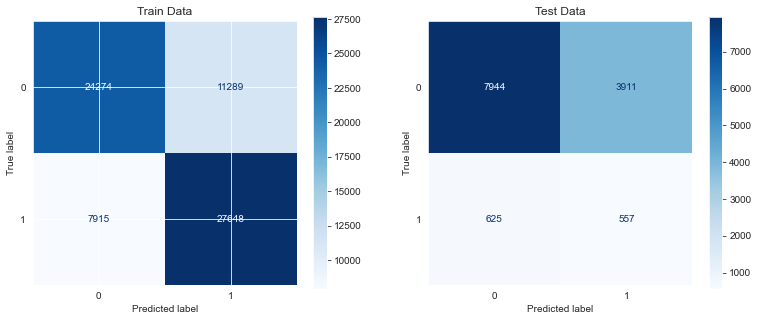

Train Data:                                 Test Data:
Accuracy:  0.7300002811911256               Accuracy:  0.6520671933727085
Recall:    0.777437224081208                Recall:    0.4712351945854484
Precision: 0.7100701132598813               Precision: 0.1246642793196061
F1:        0.7422281879194631               F1:        0.19716814159292034


In [24]:
xgb_synth = XGBClassifier(random_state=42)
xgb_synth.fit(X_train_synth, y_train_synth)

print('XGB With Synthetic Data:')
plot_confusion(xgb_synth, X_train_synth, X_test, y_train_synth, y_test)
clf_scores(xgb_synth, X_train_synth, X_test, y_train_synth, y_test)

## Tuning Parameters
It is becoming clear with each test that our current dataset is not likely to yield the results we are hoping to, as the highest F1 score (that of XG Boost with SMOTE) does not go any higher than 0.917, when we are aiming to get as close to 1 as possible.

However, it has become clear that using SMOTE will increase F1 scores, usually (as expected) at the cost of Accuracy and Precision scores. Because of this, we will only use the synthetic data going forward.

In [25]:
X_train = X_train_synth
y_train = y_train_synth

#print(y_train.value_counts())

The final step that can be attempted with the current set of features is to tune individual classifiers' hyperparameters. We will use GridSearchCV to perform an exhaustive search of some of the most common parameters to test the Logistic Regression, Random Forest, and XG Boost classifiers. 

### Logistic Regression

In [26]:
#logreg tuning

logreg = LogisticRegression(random_state=42)

logreg_param_grid = {'penalty' : ['l1', 'l2'],
                     'C' : np.logspace(-2, 2, 10),
                     'solver' :  ['liblinear']}

logreg_cv = GridSearchCV(logreg, logreg_param_grid, cv=3,scoring='f1', verbose = True, n_jobs = -1)
logreg_cv.fit(X_train, y_train)

logreg_cv.best_params_
#{'C': 0.027825594022071243, 'penalty': 'l1', 'solver': 'liblinear'}

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   30.2s finished


{'C': 0.027825594022071243, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression, unfortunately, does not have very many paramters that can be tuned to achieve worthwhile results.

### Random Forest

In [27]:
#forest tuning

forest = RandomForestClassifier(random_state=42)

forest_param_grid = {'max_depth' : [None, 3, 4],
                    'max_features' :  ['sqrt', 'log2', 2, 5, 10],
                    'n_estimators' : [10,100,1000]}

forest_cv = GridSearchCV(forest, forest_param_grid, scoring='f1', cv=3,verbose = True, n_jobs = -1)
forest_cv.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  5.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4],
                         'max_features': ['sqrt', 'log2', 2, 5, 10],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1', verbose=True)

In [28]:
forest_cv.best_params_
#{'max_depth': None, 'max_features': 10, 'n_estimators': 1000}

{'max_depth': None, 'max_features': 10, 'n_estimators': 1000}

### XGBoost

In [29]:
#more tuning 

xgb = XGBClassifier(random_state=42, n_estimators=10, learning_rate=0.001 )

xgb_param_grid = {'n_estimators' : [10, 100, 1000],
                  'learning_rate' : [0.001, 0.01, 0.1],
                  'subsample' :  np.linspace(0.1, 1, 4),
                  'max_depth' : [3, 7, 9]}
xgb_cv = GridSearchCV(xgb, xgb_param_grid, cv=3,scoring='f1', verbose = True, n_jobs = -1)
xgb_cv.fit(X_train, y_train)

xgb_cv.best_params_
#{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 26.7min finished


{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.7}

Tuned Logistic Regression:


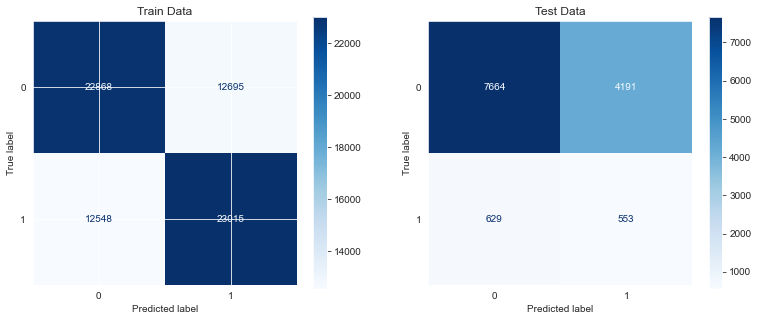

Train Data:                                 Test Data:
Accuracy:  0.6450946208137671               Accuracy:  0.6302830405768198
Recall:    0.6471613755869865               Recall:    0.46785109983079526
Precision: 0.6444973396807617               Precision: 0.11656829679595278
F1:        0.6458266103573584               F1:        0.18663516706041175


In [32]:
print('Tuned Logistic Regression:')
plot_confusion(logreg_cv, X_train, X_test, y_train, y_test)
clf_scores(logreg_cv, X_train, X_test,y_train, y_test)

Tuned Random Forest:


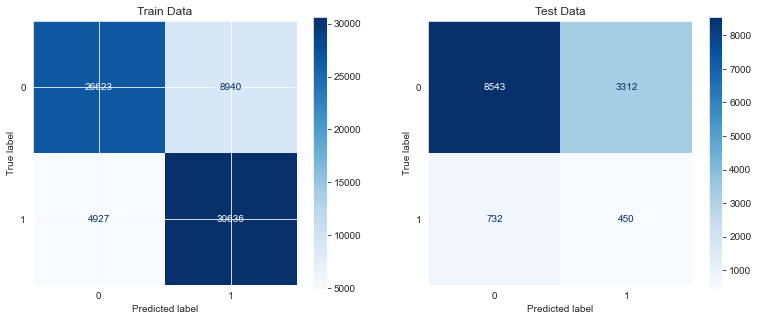

Train Data:                                 Test Data:
Accuracy:  0.8050361330596406               Accuracy:  0.6898059369486845
Recall:    0.861457132412901                Recall:    0.38071065989847713
Precision: 0.7741055184960582               Precision: 0.11961722488038277
F1:        0.8154487017394428               F1:        0.18203883495145629


In [33]:
print('Tuned Random Forest:')
plot_confusion(forest_cv,X_train, X_test, y_train, y_test)
clf_scores(forest_cv, X_train, X_test,y_train, y_test)    

Tuned XG Boost:
Train Data:                                 Test Data:
Accuracy:  0.8012681719764925               Accuracy:  0.6897292321853187
Recall:    0.8547647836234289               Recall:    0.383248730964467
Precision: 0.7721499695183905               Precision: 0.12019103210400636
F1:        0.8113597843349215               F1:        0.18299333467986265


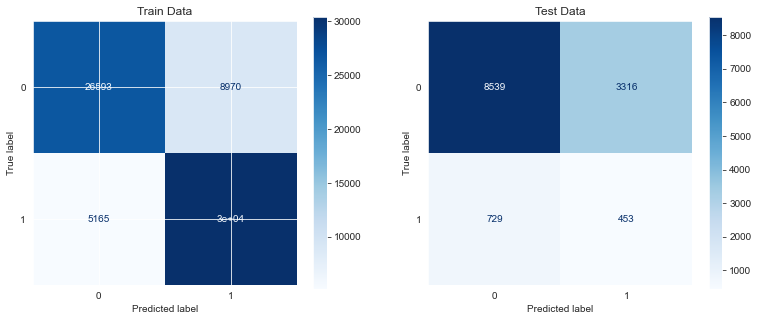

In [34]:
print('Tuned XG Boost:')
clf_scores(xgb_cv, X_train, X_test,y_train, y_test)
plot_confusion(xgb_cv, X_train, X_test, y_train, y_test)

### How to interpret this information

The best F1 score from these classifiers comes from the Logistic Regression model, but it is only 0.186, and we want it to be as close to 1 as possible. On top of that, the strongest Accuract score is from XG Boost, but it is only 0.68. Clearly there is an issue beyond the models and their parameters keeping the scores from improving.

The [following notebook](./new_features_and_targets.ipynb) will use appropriate feature selection and machine learning pipelines to see how our classifiers can be improved and altered to yield more meaningful results:

### [Feature and Target Selection](./new_features_and_targets.ipynb)